In [ ]:
import hashlib
import numpy as np
import threading
import time
import matplotlib.pyplot as plt
import scipy.stats as st
from concurrent.futures import ThreadPoolExecutor

In [ ]:
SIZE = 100
D_SIZE = 20
delay = 74
std = 20
r = 0


class Node:
    lock = threading.Lock()

    def __init__(self, id):
        self.id = id
        self.delegates = []

    def append_delegate(self, sender_id, delay_limit):
        if len(self.delegates) == 0:
            self.start = time.perf_counter()
        if sender_id != self.id:
            time.sleep(abs(np.random.normal(delay, std)) * 0.1**4)
        if time.perf_counter() - self.start < delay_limit * 0.1**4:
            with self.lock:
                self.delegates.append(sender_id)

    # for multi-threading
    def select_delegate(self, nodes, r, delay_limit):
        if int(hashlib.sha256(str(r).encode()).hexdigest(), 16) % SIZE in [(self.id + k) % SIZE for k in range(D_SIZE)]:
            for n in nodes:
                n.append_delegate(self.id, delay_limit)

def execute_simu(delay_limit):
    nodes = [Node(i) for i in range(SIZE)]
    with ThreadPoolExecutor() as executor:
        for n in nodes:
            executor.submit(n.select_delegate, nodes, r, delay_limit)
    and_set = set(nodes[0].delegates)
    or_set = set(nodes[0].delegates)
    nodes_num = len(nodes)
    for i in range(1, nodes_num):
        n_set = set(nodes[i].delegates)
        and_set &= n_set
        or_set |= n_set
    return float(len(and_set)) / len(or_set) if len(or_set) != 0 else 0.0

In [ ]:
itr = 10
delay_limits = np.arange(0, 1001, 10)
mean, ci_low, ci_up = [], [], []
for delay_lim in delay_limits:
    data = [execute_simu(delay_lim) for _ in range(itr)]
    mean.append(np.mean(data))
    ci = st.t.interval(0.95, len(data)-1, loc=np.mean(data), scale=st.sem(data))
    ci_low.append(ci[0])
    ci_up.append(ci[1])

/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


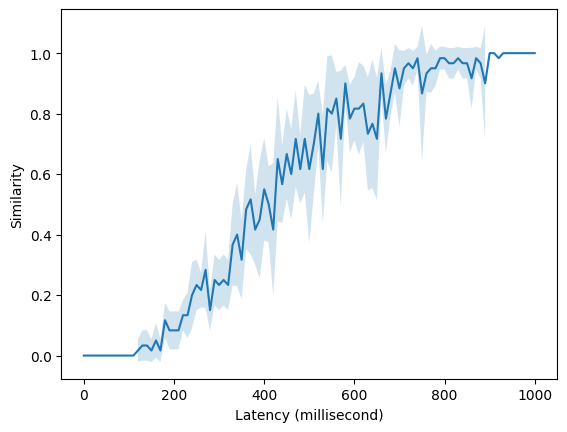

In [ ]:
plt.plot(delay_limits, mean)
plt.fill_between(delay_limits, ci_low, ci_up, alpha=0.2)
plt.xlabel('Latency (millisecond)')
plt.ylabel('Similarity')
plt.show()

<ipython-input-5-e6e9ef0bfc30>:1: RuntimeWarning: divide by zero encountered in reciprocal
  delay_ratios = np.reciprocal(delay_limits / delay)


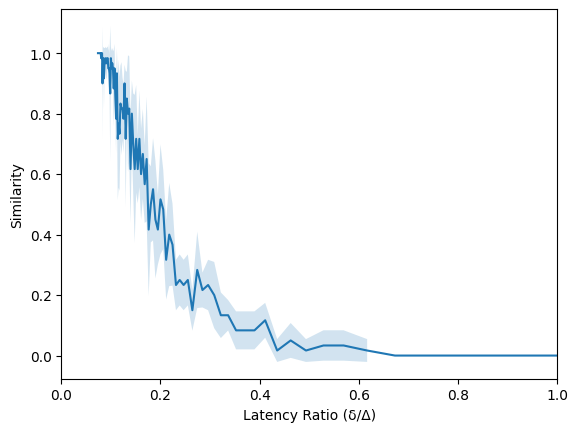

In [ ]:
delay_ratios = np.reciprocal(delay_limits / delay)
plt.plot(delay_ratios, mean)
plt.fill_between(delay_ratios, ci_low, ci_up, alpha=0.2)
plt.xlim(0, 1)
plt.xlabel('Latency Ratio (δ/Δ)')
plt.ylabel('Similarity')
plt.show()

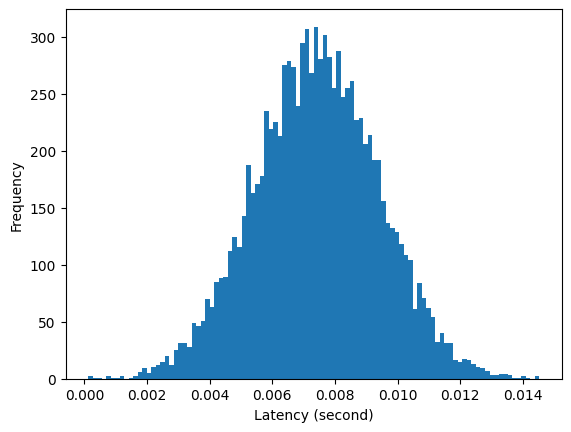

In [ ]:
sample = abs(np.random.normal(delay, std, 10000)) * 0.1**4
plt.hist(sample, bins=100)
plt.xlabel('Latency (second)')
plt.ylabel('Frequency')
plt.show()